# Predicting Composer of a Musical Piece
## AAI-511 Team 7 Final Project

Team 7:  Tyler Foreman

University of San Diego, Applied Artificial Intelligence

Date:  August 12, 2024

GitHub Repository: https://github.com/t4ai/aai-511-final-project

In [1]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.4 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=b277d785c53f28c970a6ea579c60887a41c1b49c6f7a4963819a8cecbf0ee47f
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from random import sample
import os
import shutil
import pretty_midi

## Data Organization and Exploratory Analysis

1.  Extract music files for only the composers of interest - remove all others
2.  Conduct EDA on the target data:
  - Undersand the nature of the files and formats
  - Evaluate the distribution of samples by composer/class
  - Evaluate the length of the music tracks (in time)
  - Identify any preparation or augmentation tasks that may be necessary

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# setup target data locations
root_data_path = '/content/drive/MyDrive/USD/datasets/composers_music'
target_data_path = '/content/drive/MyDrive/USD/datasets/composers_music/target'

In [5]:
# setup data prep parameters
SAMPLE_FREQUENCY = 20

# helper function for moving and flattening directories by composer
def move_and_flatten(composer_name):
  # setup destination
  target_path = target_data_path + '/' + composer_name
  os.makedirs(target_path, exist_ok=True)

  # get source dir and subdirs
  composer_path = root_data_path + '/midiclassics/' + composer_name
  composer_dirs = [x[0] for x in os.walk(composer_path)]

  # traverse directories
  num_files = 0
  for dir in composer_dirs:
    for filename in os.listdir(dir):
      if os.path.isfile(os.path.join(dir, filename)):
        shutil.copyfile(dir + '/' + filename, target_path + '/' + filename)
        num_files += 1
  print(f'Moved {num_files} files for {composer_name}')

# helper function for loading piano rolls for a composer
def load_piano_rolls(composer_name, frequency):
  piano_rolls = []
  target_path = target_data_path + '/' + composer_name
  for filename in os.listdir(target_path):
    if filename.lower().endswith('.mid'):
      try:
        midi = pretty_midi.PrettyMIDI(target_path + '/' + filename)
        midi.remove_invalid_notes()
        piano_rolls.append(midi.get_piano_roll(fs=frequency))
      except Exception as e:
        print(f'Error reading {filename}: {e}')
  return piano_rolls

In [ ]:
# extract only the files from our taget 4 composers: Bach, Beethoven, Mozart, Chopin
os.makedirs(target_data_path, exist_ok=True)

move_and_flatten('Bach')
move_and_flatten('Beethoven')
move_and_flatten('Mozart')
move_and_flatten('Chopin')

Moved 1025 files for Bach
Moved 219 files for Beethoven
Moved 257 files for Mozart
Moved 136 files for Chopin


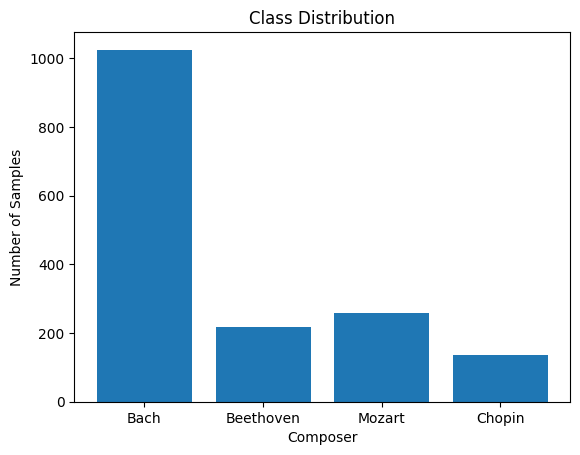

In [ ]:
# visualize class balances
class_samples = {"Bach": 1025, "Beethoven": 219, "Mozart": 257, "Chopin": 136}
plt.bar(class_samples.keys(), class_samples.values())
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [6]:
# get the distribution of sequence lengths of the pieces (in time)
bach_data = load_piano_rolls('Bach', SAMPLE_FREQUENCY)
beethoven_data = load_piano_rolls('Beethoven', SAMPLE_FREQUENCY)
mozart_data = load_piano_rolls('Mozart', SAMPLE_FREQUENCY)
chopin_data = load_piano_rolls('Chopin', SAMPLE_FREQUENCY)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error reading Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error reading K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


In [7]:
# build length distribution
length_distributions = []
def append_lengths(data):
  for i in range(len(data)):
    length_distributions.append(data[i].shape[1])

In [ ]:
# concatenate all classes
append_lengths(bach_data)
append_lengths(beethoven_data)
append_lengths(mozart_data)
append_lengths(chopin_data)

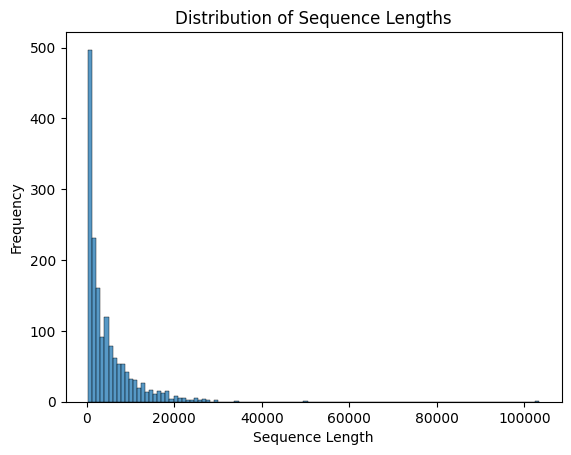

In [ ]:
# plot the distribution
sns.histplot(length_distributions)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [ ]:
# get descriptive statistics for sequence lengths
stats_df = pd.DataFrame(length_distributions)
stats_df.describe()

,0
count,1628.000000
mean,4838.340909
std,5900.262705
min,350.000000
25%,1019.750000
50%,2647.000000
75%,6518.250000
max,103362.000000


#### Analysis

There is a significant class imbalance, where Bach pieces far outweigh the number of pieces by the other composers.  Some balancing will be required - likely starting with using a subset of the Bach pieces.

There is also a wide range of sequence values.  Some preparation tasks will likely be required to normalize these to a standard sequence length for the model.  We can use the descriptive statistics to determine this - possibly breaking the larger tracks into multiple samples, each with a smaller sequence length.

## Data Preparation

1.  Fix the class imbalance issue by downsampling the over-represented class (Bach)
2.  Process the tracks into smaller, normalized sequence lengths
3.  Format the dataset into samples and labels suitable for model input
4.  Split the result into train/test/val

In [49]:
# set a normalized sequence length to 1 min/60 s worth of samples
NORM_SEQUENCE_LENGTH = SAMPLE_FREQUENCY * 60

# helper function to pad sequences not quite long enough
def zero_pad(seq, x, missing):
	right = np.zeros((x, missing))
	return np.hstack((seq,right))

# helper function to process track into sequences of normalized length
def process_track_to_sequences(track):
  x,y = track.shape
  #print(f"track shape:", track.shape)
  sequences = []
  if(y < NORM_SEQUENCE_LENGTH):
    sequence = zero_pad(track, x, NORM_SEQUENCE_LENGTH-y)
    #print(f"short sequence len:", sequence.shape)
    sequences.append(sequence)
  else:
    num_sequences = int(np.ceil(y / NORM_SEQUENCE_LENGTH))
    for i in range(num_sequences):
      start = i * NORM_SEQUENCE_LENGTH
      if start + NORM_SEQUENCE_LENGTH > y:
        sequence = track[:,start:y]
        zp = zero_pad(sequence, x, (start + NORM_SEQUENCE_LENGTH - y))
        #print(f"zp sequence len:", zp.shape)
        sequences.append(zp)
      else:
        end = start + NORM_SEQUENCE_LENGTH
        sequence = track[:,start:end]
        #print(f"sequence len:", sequence.shape)
        sequences.append(sequence)

  return sequences

# helper function to process all tracks for a composer into sequences
def process_composer_sequences(composer_data):
  composer_sequences = []
  for i in range(len(composer_data)):
    sequences = process_track_to_sequences(composer_data[i])
    for seq in sequences:
      #print(seq.shape)
      composer_sequences.append(seq)
  return composer_sequences

In [50]:
# process data into sequences for each composer
bach_sequences = process_composer_sequences(bach_data)
beethoven_sequences = process_composer_sequences(beethoven_data)
mozart_sequences = process_composer_sequences(mozart_data)
chopin_sequences = process_composer_sequences(chopin_data)

In [52]:
# display sequence lenghths:
print(f'Bach: {len(bach_sequences)}')
print(f'Beethoven: {len(beethoven_sequences)}')
print(f'Mozart: {len(mozart_sequences)}')
print(f'Chopin: {len(chopin_sequences)}')

Bach: 3109
Beethoven: 1823
Mozart: 1832
Chopin: 568


In [44]:
#randomly downsample Bach sequences
#bach_sequences = sample(bach_sequences, 4000)

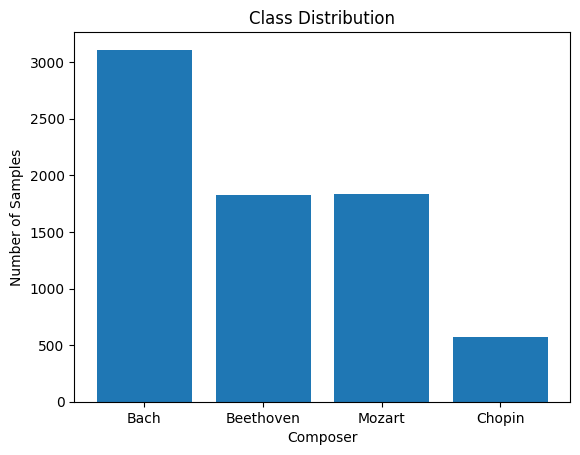

In [53]:
# visualize class balances
class_samples = {"Bach": len(bach_sequences), "Beethoven": len(beethoven_sequences), "Mozart": len(mozart_sequences), "Chopin": len(chopin_sequences)}
plt.bar(class_samples.keys(), class_samples.values())
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [57]:
# create labels
bach_labels = ['bach'] * len(bach_sequences)
beethoven_labels = ['beethoven'] * len(beethoven_sequences)
mozart_labels = ['mozart'] * len(mozart_sequences)
chopin_labels = ['chopin'] * len(chopin_sequences)

In [59]:
# next stack the sequences into single list
X = np.concatenate((bach_sequences, beethoven_sequences, mozart_sequences, chopin_sequences))
y = np.concatenate((bach_labels, beethoven_labels, mozart_labels, chopin_labels))


In [67]:
# shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

In [70]:
# label encode the labels
le = LabelEncoder()
y = le.fit_transform(y)
y

array([3, 3, 0, ..., 0, 0, 0])

In [71]:
# split into train/test/val
TRAIN_SPLIT = 0.8
TEST_VAL_SPLIT = 0.1
TOTAL_LEN = len(X)

# train data
X_train = X[:int(TOTAL_LEN * TRAIN_SPLIT)]
y_train = y[:int(TOTAL_LEN * TRAIN_SPLIT)]

# val data
X_val = X[int(TOTAL_LEN * TRAIN_SPLIT):int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT))]
y_val = y[int(TOTAL_LEN * TRAIN_SPLIT):int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT))]

# test data
X_test = X[int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT)):]
y_test = y[int(TOTAL_LEN * (TRAIN_SPLIT + TEST_VAL_SPLIT)):]